In [ ]:
!pip3 install torch torchvision

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

## Tensor transformation
````transforms.Normalize((0.5,), (0.5,))```` receive two arguments, first one is the mean and second one is the standard deviation (STD),
all pixels are normalize to this range.<br>
We normalize the image to ````(-1, 1)```` help reduce skewness and distortion of the image

$
minimum value = (0-0.5)/0.5=-1
$

$
maximum value = (1-0.5)/0.5=1
$

In [11]:
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

<u>````im_convert(tensor)````</u> <br><br>convert the image tensor back to numpy array<br>
We use ````detach```` to remove gradient computational.<br>

- tensor argumant: has a shape of $(1, 28, 28)$<br>

To plot the image we require a shape of $(28, 28, 1)$ then denormalize back to (0, 1) by using:<br>
```image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))```

```image.transpose(1, 2, 0):``` will swap axis 0 for axis 1, axis 1 for axis 2 then add axis 0 in the end<br><br>
The result `image` is a numpy array of $(28, 28, 1)$

In [12]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

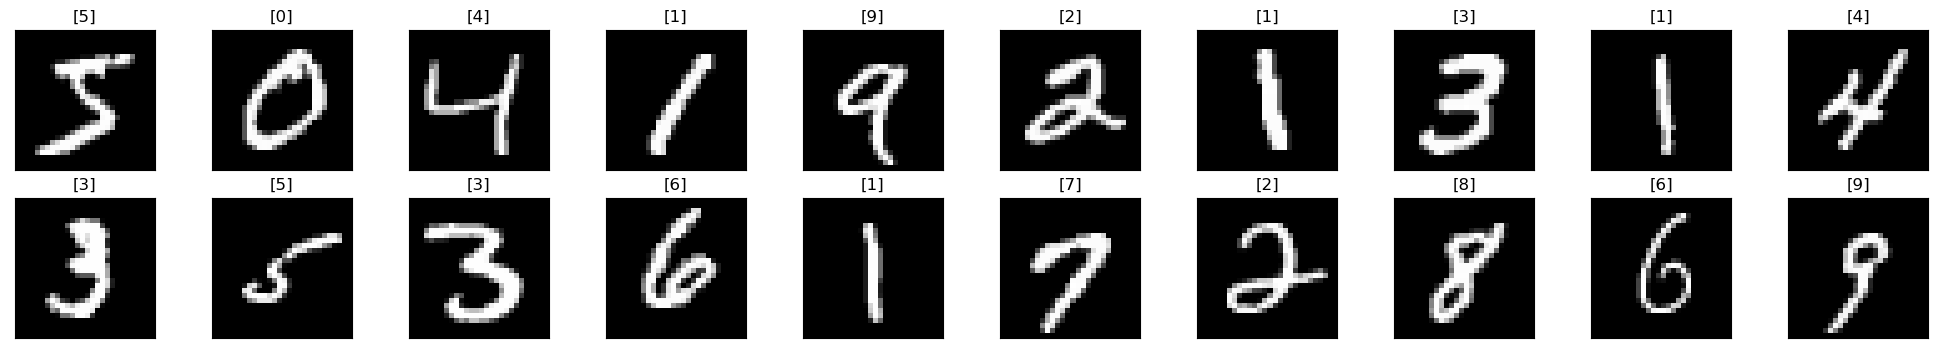

In [26]:
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  image, label = training_dataset[idx]

  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(image))
  ax.set_title([label])


# Create the classifier
We will define a two hidden layers<br>
- `D_in` the size of the input layer
- `H1` the number of node in the first hidden layer
- `H2` the number of node in the second hidden layer
- `out` the size of the output layer

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

>The output of the `forward` method is the 'rew' output of linear3. Is in intentional since we want to use `nn.CrossEntropyLoss`. Because cross entropy is using logs we just need to pass rew inputs.

`nn.CrossEntropyLoss` calculate the cross entropy <i><b>and</b></i> and the loss itself.

In [27]:
class Classifier(nn.Module):
    
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))  
        x = F.relu(self.linear2(x))
        x = self.linear3(x)        
        return x

In [29]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [31]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.9413, acc 78.0033 
validation loss: 0.4153, validation acc 89.0000 
epoch : 2
training loss: 0.3746, acc 89.5317 
validation loss: 0.3252, validation acc 90.6800 
epoch : 3
training loss: 0.3159, acc 90.9517 
validation loss: 0.2868, validation acc 91.6800 
epoch : 4
training loss: 0.2838, acc 91.7883 
validation loss: 0.2681, validation acc 92.0300 
epoch : 5
training loss: 0.2597, acc 92.5000 
validation loss: 0.2469, validation acc 92.6400 
epoch : 6
training loss: 0.2401, acc 93.0250 
validation loss: 0.2279, validation acc 93.3700 
epoch : 7
training loss: 0.2223, acc 93.6050 
validation loss: 0.2114, validation acc 93.7200 
epoch : 8
training loss: 0.2068, acc 94.0333 
validation loss: 0.1992, validation acc 94.0500 
epoch : 9
training loss: 0.1935, acc 94.4300 
validation loss: 0.1863, validation acc 94.4600 
epoch : 10
training loss: 0.1802, acc 94.7333 
validation loss: 0.1740, validation acc 94.7800 
epoch : 11
training loss: 0.1692, acc 95.1050 
va

KeyboardInterrupt: 

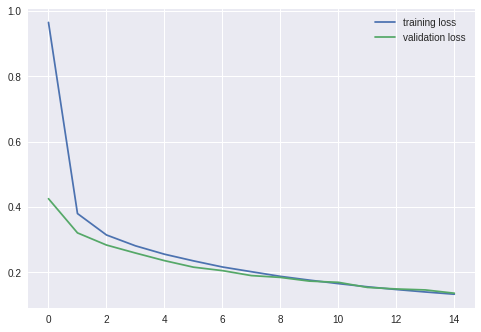

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

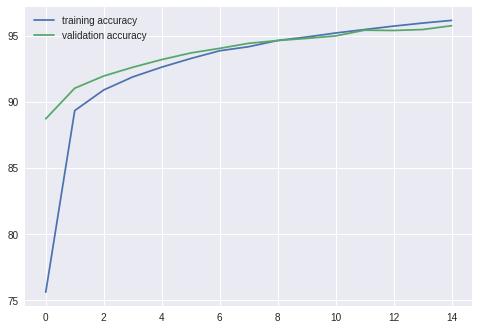

In [ ]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [ ]:
!pip3 install pillow==4.0.0

In [ ]:
import PIL.ImageOps

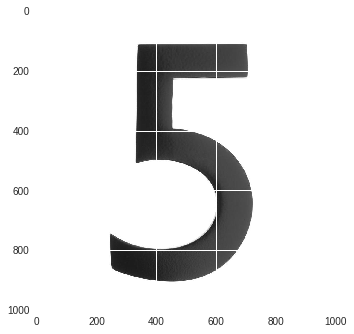

In [ ]:
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

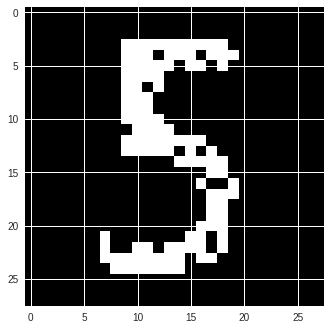

In [ ]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(im_convert(img))

In [ ]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item())

5


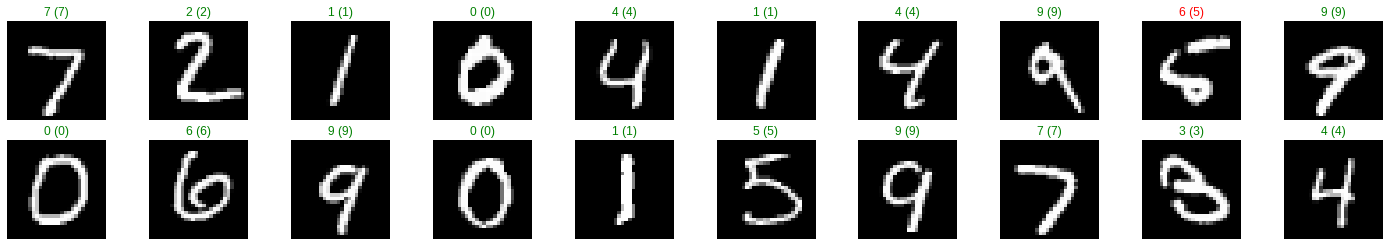

In [ ]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))